# Critical memory capacity vs number of network motifs 

In [1]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function, absolute_import

import numpy as np
import networkx as nx
import pandas as pd
import random

from reservoir_tools.utils import get_spectral_radius, nrmse, bisection, get_args_index, is_number
from reservoir_tools.control_graphs import control_graphs, randomize_network
from reservoir_tools.datasets import narma10, narma30
from reservoir_tools.tasks import memory_capacity, critical_memory_capacity
from reservoir_tools.readouts import LinearRegression, RidgeRegression
from reservoir_tools.reservoirs import simulate_reservoir_dynamics, remove_node
from reservoir_tools import grn_networks
from reservoir_tools import network_tools as nt
from reservoir_tools.network_statistics import average_degree, connectivity_fraction
from reservoir_tools.load_preserving_sign import load_preserving_signs

In [4]:
import json

with open('data/dict3187.json', 'r') as f:
    dict_nrnodes_list = { int(key) : [item for item in value] for key, value in json.load(f).items()}

error_mean, error_std, nr_incoherent_ffl, nr_neg_feed = np.loadtxt("data/dict3187.txt", delimiter=' ', usecols=(0, 1,2,3), unpack=True,skiprows=1)

nr_2_feedback, nr_selfloops = np.loadtxt("data/feedback2_selfLOOPS.txt", delimiter=' ', usecols=(0, 1), unpack=True,skiprows=1)

with open('data/node_arrow_FFL_1000_mean.txt', 'r') as f:
    node_arrow_FFL = { key : value for key, value in json.load(f).items()}

with open('data/node_arrow_SELF_1000_mean.txt', 'r') as f:
    node_arrow_SELF = { key : value for key, value in json.load(f).items()}

with open('data/node_arrow_feedback_two_1000_mean_norm.txt', 'r') as f:
    node_arrow_feedback_two = { key : value for key, value in json.load(f).items()}

In [5]:
G=load_preserving_signs("reservoir_tools/red_simplificada.txt")
graph = nt.prune_graph(G, verbose=1)

Deleted nodes: 3064 (23 roots, 3041 leaves)
Deleted nodes: 95 (2 roots, 93 leaves)
Deleted nodes: 14 (0 roots, 14 leaves)
Deleted nodes: 2 (0 roots, 2 leaves)
Deleted nodes: 1 (0 roots, 1 leaves)


In [25]:
cuantas_redes = 0
redes_24_nod_error = []
self_redes_24_nod_nro = []
self_nr_expected_FFL_NF24 = []
feedb_redes_24_nod_nro = []
feedb_nr_expected_FFL_NF24 = []
feedf_redes_24_nod_nro = []
feedf_nr_expected_FFL_NF24 = []
tamm = []
identificador = []

for key in dict_nrnodes_list.keys():
    for value in dict_nrnodes_list[key]:
        
        if len(value) > 3:
            k = graph.subgraph(value)
            H = k.copy()
            G2 = H.to_undirected()
            Gcc = sorted(nx.connected_components(G2), key=len, reverse=True)
            k2 = k.subgraph(Gcc[0])
            if k2.number_of_nodes() == k.number_of_nodes():
                redes_24_nod_error.append(error_mean[cuantas_redes])
                self_redes_24_nod_nro.append(nr_selfloops[cuantas_redes])
                feedb_redes_24_nod_nro.append(nr_2_feedback[cuantas_redes])
                feedf_redes_24_nod_nro.append(nr_incoherent_ffl[cuantas_redes])
                tamm.append(len(value))
                arrows = H.number_of_edges()
                noodes = H.number_of_nodes()
                self_nr_expected_FFL_NF24.append(nr_selfloops[cuantas_redes]/node_arrow_SELF["(" + str(noodes) + ", " + str(arrows) + ")"])
                feedb_nr_expected_FFL_NF24.append(nr_2_feedback[cuantas_redes]/node_arrow_feedback_two["(" + str(noodes) + ", " + str(arrows) + ")"])
                feedf_nr_expected_FFL_NF24.append(nr_incoherent_ffl[cuantas_redes]/node_arrow_FFL["(" + str(noodes) + ", " + str(arrows) + ")"])
                identificador.append(cuantas_redes)
        cuantas_redes =cuantas_redes + 1 

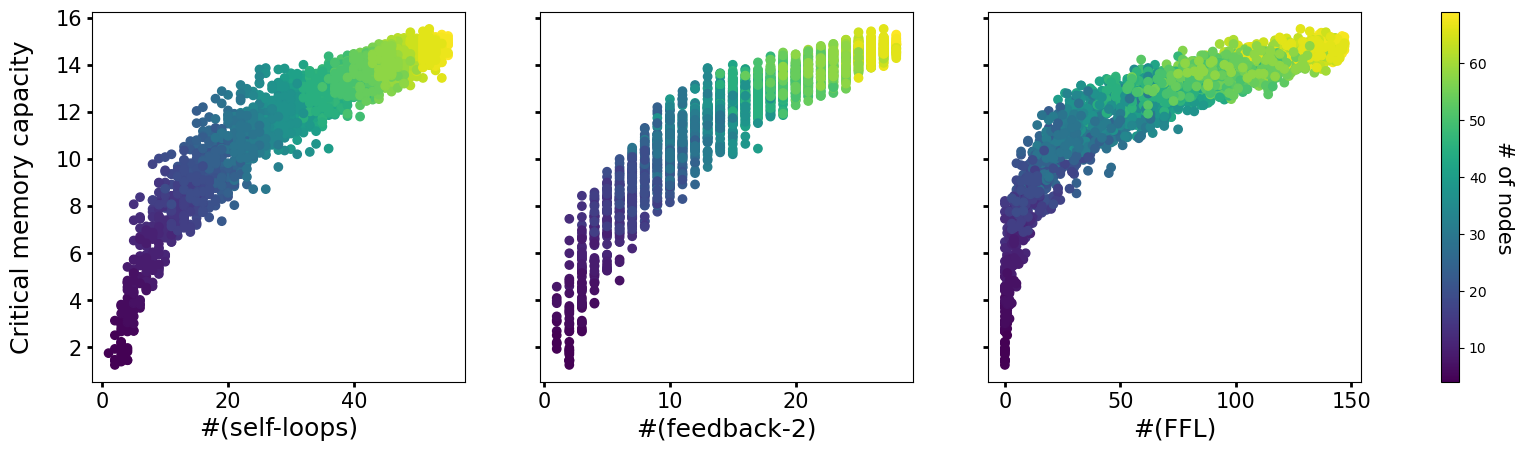

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize = (3.2*6.4, 4.8), nrows=1, ncols=3, sharey=True)
ax = axes.flatten()


im = ax[0].scatter(self_redes_24_nod_nro, redes_24_nod_error, c=tamm)
ax[0].set_ylabel("Critical memory capacity", labelpad=15.4, size=18)

ax[0].set_xlabel("#(self-loops)", size=18)
ax[0].tick_params(width=2, axis='both', which='major', labelsize=15)



im = ax[1].scatter(feedb_redes_24_nod_nro, redes_24_nod_error, c=tamm)
ax[1].set_ylabel(" ", size=14)
ax[1].set_xlabel("#(feedback-2)", size=18)
ax[1].tick_params(width=2, axis='both', which='major', labelsize=15)


im = ax[2].scatter(feedf_redes_24_nod_nro, redes_24_nod_error, c=tamm)
ax[2].set_ylabel(" ", size=14)
ax[2].set_xlabel("#(FFL)", size=18)
ax[2].tick_params(width=2, axis='both', which='major', labelsize=15)


cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
cbar =plt.colorbar(im, cax=cax,  pad=-10.4, **kw)

#cbar = plt.colorbar(sc) 
cbar.set_label('# of nodes', rotation=270, labelpad=20, size=15)

#plt.tight_layout()
#plt.savefig('lyapunov.png', dpi=300)
#plt.savefig('motifs_mem_cap.pdf',bbox_inches='tight')

plt.show()

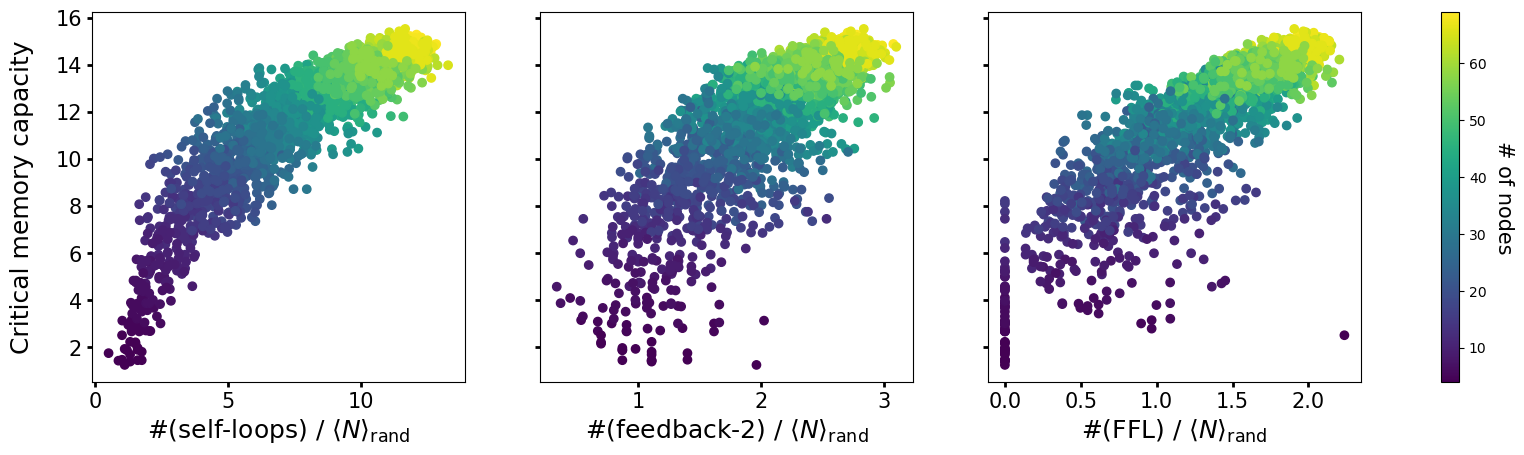

In [27]:
import matplotlib as mpl
fig, axes = plt.subplots(figsize = (3.2*6.4, 4.8), nrows=1, ncols=3, sharey=True)
ax = axes.flatten()


im = ax[0].scatter(self_nr_expected_FFL_NF24, redes_24_nod_error, c=tamm)
ax[0].set_ylabel("Critical memory capacity", labelpad=15.4, size=18)

ax[0].set_xlabel(r"#(self-loops) / $\left \langle N \right \rangle_{\mathrm{rand}}$", size=18)
ax[0].tick_params(width=2, axis='both', which='major', labelsize=15)



im = ax[1].scatter(feedb_nr_expected_FFL_NF24, redes_24_nod_error, c=tamm)
ax[1].set_ylabel(" ", size=14)
ax[1].set_xlabel(r"#(feedback-2) / $\left \langle N \right \rangle_{\mathrm{rand}}$", size=18)
ax[1].tick_params(width=2, axis='both', which='major', labelsize=15)


im = ax[2].scatter(feedf_nr_expected_FFL_NF24, redes_24_nod_error, c=tamm)
ax[2].set_ylabel(" ", size=14)
ax[2].set_xlabel(r"#(FFL) / $\left \langle N \right \rangle_{\mathrm{rand}}$", size=18)
ax[2].tick_params(width=2, axis='both', which='major', labelsize=15)


cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
cbar =plt.colorbar(im, cax=cax,  pad=-10.4, **kw)

#cbar = plt.colorbar(sc) 
cbar.set_label('# of nodes', rotation=270, labelpad=20, size=15)

#plt.tight_layout()
#plt.savefig('lyapunov.png', dpi=300)
#plt.savefig('motifs_mem_cap_NORM.pdf',bbox_inches='tight')

plt.show()

In [17]:
mem_self_loops = []
for i in range(len(tamm)):
    if self_redes_24_nod_nro[i]<=28:
        mem_self_loops.append(redes_24_nod_error[i])

mem_feedback2 = []
for i in range(len(tamm)):
    if feedb_redes_24_nod_nro[i]<=28:
        mem_feedback2.append(redes_24_nod_error[i])

mem_FFL = []
for i in range(len(tamm)):
    if feedf_redes_24_nod_nro[i]<=28:
        mem_FFL.append(redes_24_nod_error[i])

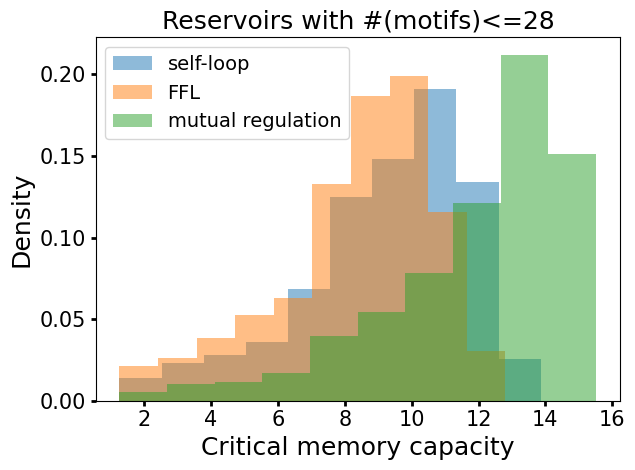

In [18]:
import random
import numpy
from matplotlib import pyplot

pyplot.hist(mem_self_loops,  density=True,  alpha=0.5, label='self-loop')
pyplot.hist(mem_FFL,  density=True,  alpha=0.5, label='FFL')
pyplot.hist(mem_feedback2,  density=True,  alpha=0.5, label='mutual regulation')
#pyplot.hist(mem_feedback2_selfloops,  alpha=0.5, label='mem_feedback2_selfloops')
pyplot.legend(loc='upper left', fontsize=14)
pyplot.xlabel("Critical memory capacity", fontsize=18)
pyplot.ylabel("Density", fontsize=18)
pyplot.title("Reservoirs with #(motifs)<=28", fontsize=18)

pyplot.tick_params(width=2, axis='both', which='major', labelsize=15)
#plt.savefig('lyapunov.png', dpi=300)
#plt.savefig('density_less28.pdf',bbox_inches='tight')
pyplot.tight_layout()
pyplot.show()

In [21]:
mem_self_loops = []
for i in range(len(tamm)):
    if self_redes_24_nod_nro[i]<=55:
        mem_self_loops.append(redes_24_nod_error[i])

mem_feedback2 = []
for i in range(len(tamm)):
    if feedb_redes_24_nod_nro[i]<=55:
        mem_feedback2.append(redes_24_nod_error[i])

mem_FFL = []
for i in range(len(tamm)):
    if feedf_redes_24_nod_nro[i]<=55:
        mem_FFL.append(redes_24_nod_error[i])

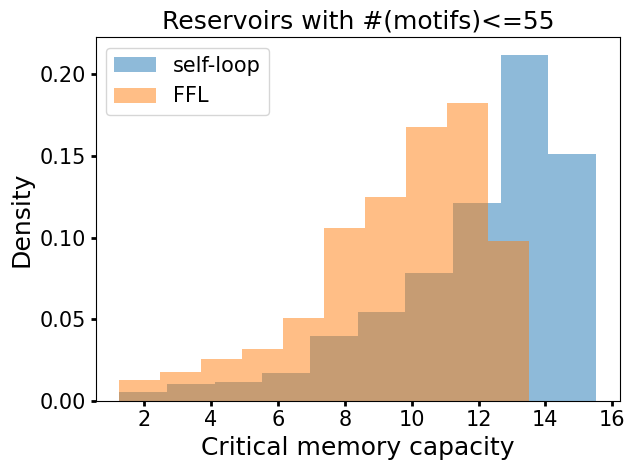

In [22]:
import random
import numpy
from matplotlib import pyplot

pyplot.hist(mem_self_loops,  density=True,  alpha=0.5, label='self-loop')
pyplot.hist(mem_FFL,  density=True,  alpha=0.5, label='FFL')
#pyplot.hist(mem_feedback2,  density=True,  alpha=0.5, label='feedback-2')
#pyplot.hist(mem_feedback2_selfloops,  alpha=0.5, label='mem_feedback2_selfloops')
pyplot.legend(loc='upper left', fontsize=15)
pyplot.xlabel("Critical memory capacity", fontsize=18)
pyplot.ylabel("Density", fontsize=18)
pyplot.title("Reservoirs with #(motifs)<=55", fontsize=18)

pyplot.tick_params(width=2, axis='both', which='major', labelsize=15)
#plt.savefig('lyapunov.png', dpi=300)
#plt.savefig('density_less55.pdf',bbox_inches='tight')
pyplot.tight_layout()
pyplot.show()